In [10]:
# Importar librerías 
from Backtesting import BackTesting, return_next_q, get_market_prices
from locale import setlocale, LC_TIME
import matplotlib.pyplot as plt
from valuation import Companies
import yfinance as yf
import seaborn as sns
import DataFunctions
import pandas as pd
import numpy as np
import warnings
import joblib

In [2]:
# Cargar Datos
income_statement = DataFunctions.load_full_excel('Data/Income/Income_Statement.xlsx')
balance_statement = DataFunctions.load_full_excel('Data/Balance/Balance_Statement.xlsx')
sp500 = DataFunctions.assets(income_statement=income_statement)

# Si se desea cambiar de periodo de analisis cambiar la siguiente fecha:
prices = yf.download(tickers=sp500, start='2018-09-01', end='2023-09-23', progress=False)['Adj Close'] 

# Filtrado de fechas y correcciones temporales
prices_fiscal = DataFunctions.prices_date(balance_statement=balance_statement, prices=prices, sp500=sp500)

# DataFrame limpio con información consolidada de ambos estados financieros y precios
financial_info = DataFunctions.clean_df(balance_statement=balance_statement, 
                                    income_statement=income_statement, 
                                    sp500=sp500, 
                                    prices_fiscal=prices_fiscal)

# Datos en formato tabular
data_table = DataFunctions.tabular_df(financial_info=financial_info, sp500=sp500)

# Cálculo de ratios financieros 
stock = Companies(data_table)
stock.get_ratios()

# EDA con miras a limpieza de datos
DataFunctions.dqr(stock.ratios)

# Limpieza
stock.clean_ratios()
stock.clean


1 Failed download:
['ABC']: Exception('%ticker%: No data found, symbol may be delisted')


,Stock,fiscalDateEnding,PER,PBV,Acid_test,ATR,CCC,ROA,DER,NPM,EM,Return
0,A,2023-06-30,117.226398,3.280427,26.970165,0.156505,484.824339,0.027984,0.866805,0.178804,1.866805,1
1,A,2023-03-31,115.687540,3.729464,12.466387,0.159538,473.104821,0.032237,0.946693,0.202067,1.946693,1
2,A,2022-12-31,119.300066,4.168479,76.111111,0.174041,425.001250,0.034941,0.985297,0.200764,1.985297,1
3,A,2022-09-30,108.403270,3.401820,14.888889,0.163201,419.650125,0.031381,1.059320,0.192285,2.059320,0
4,A,2022-06-30,128.247936,3.361065,15.462857,0.151698,416.910303,0.026208,1.041195,0.172762,2.041195,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14,XRAY,2019-12-31,197.198245,1.773366,4.074675,0.101090,520.351878,0.008993,0.990733,0.088959,1.990733,1
15,XRAY,2019-09-30,434.443223,1.833476,26.970165,0.116104,445.294066,0.004220,0.816937,0.036349,1.816937,0
16,XRAY,2019-06-30,450.749824,1.958479,26.970165,0.104921,447.986379,0.004345,0.760390,0.041411,1.760390,1
17,XRAY,2019-03-31,8354.720484,1.679904,26.970165,0.118376,407.148055,0.000201,0.777601,0.001699,1.777601,0


In [3]:
database = stock.clean.copy()
loaded_model = joblib.load(open('GBC_bagging_model.pkl', 'rb'))

setlocale(LC_TIME, 'en_US.UTF-8')

# Model
#database.to_csv('data.csv')
data = pd.read_csv('data.csv').drop('Unnamed: 0', axis=1)
data['fiscalDateEnding'] = pd.to_datetime(data['fiscalDateEnding'], format='%Y-%m-%d')
data['Yhat'] = loaded_model.predict(data.drop(['Stock', 'fiscalDateEnding', 'Return'], axis=1))
data = data.sort_values(by = 'fiscalDateEnding', ascending = True)

# Prices
prices = stock.df[['Stock','fiscalDateEnding','Adj Close']]
prices = prices.sort_values(by = 'fiscalDateEnding')

data = data.merge(prices, how = 'left', on = ['fiscalDateEnding','Stock'])

In [4]:
rf = pd.read_csv("^IRX.csv")
rf.Date = pd.to_datetime(rf['Date'], format='%m/%d/%y')

rf["rf"] = rf["Adj Close"]
rf.drop(["Adj Close"],axis=1 ,inplace=True)

rf["fiscalDateEnding"] = rf.Date
rf.drop(["Date"],axis=1 ,inplace=True)

rf.fillna(method='ffill', inplace=True)

data = data.merge(rf, on="fiscalDateEnding")

investment_rf = {0: 1, 
                 1: 0.8, 
                 2: 0.6, 
                 3: 0.4, 
                 4: 0.2, 
                 5: 0}

initial_capital = 1000000
comission = .00025

#date = '2018-12-31'
date = '2019-06-30'
trade_period = data[data['fiscalDateEnding'] == date]

In [5]:
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
new_data = data.copy()
for stock in ['CARR', 'OTIS', 'OGN', 'CEG', 'GEHC','CTVA']:
    new_data = new_data[new_data['Stock'] != stock]
value_in_time, operations = BackTesting(new_data)

                    Benchmark     Strategy
------------------  ------------  ----------
Start Period        2019-06-30    2019-06-30
End Period          2023-06-30    2023-06-30
Risk-Free Rate      5.0%          5.0%
Time in Market      13.0%         100.0%

Cumulative Return   -100.0%       253.25%
CAGR﹪              -100.0%       24.32%

Sharpe              3.97          11.99
Prob. Sharpe Ratio  94.52%        100.0%
Sortino             50627.02      784.25
Sortino/√2          35798.71      554.55
Omega               134.33        134.33

Max Drawdown        -100.0%       -0.33%
Longest DD Days     1278          92

Gain/Pain Ratio     12759.29      144.34
Gain/Pain (1M)      12759.29      144.34

Payoff Ratio        -             -
Profit Factor       12760.29      145.34
Common Sense Ratio  162824899.97  9833.38
CPC Index           -             -
Tail Ratio          12760.29      67.66
Outlier Win Ratio   6.38          46333.39
Outlier Loss Ratio  0.43          177.06

MTD        

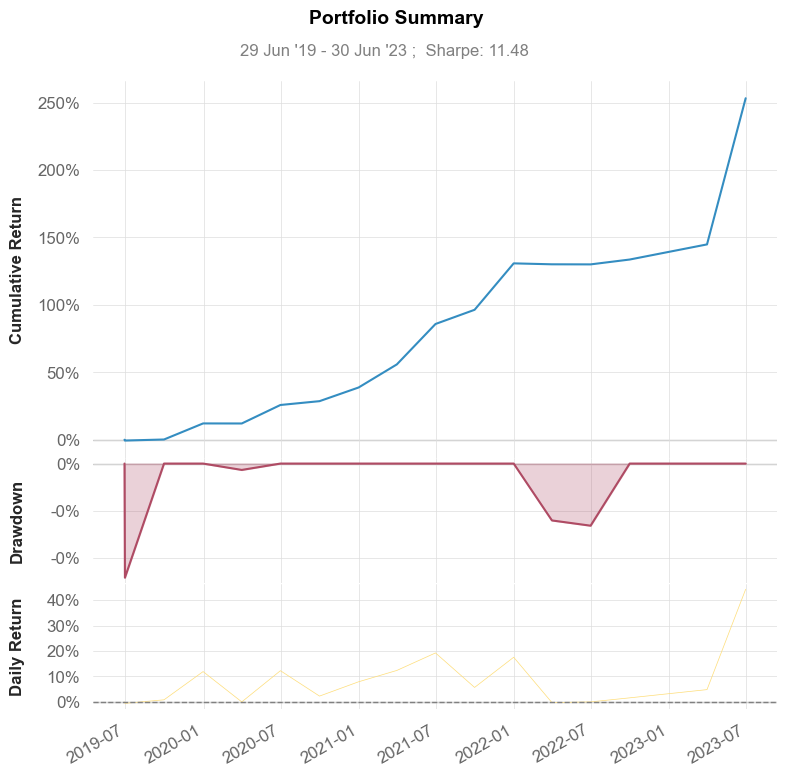

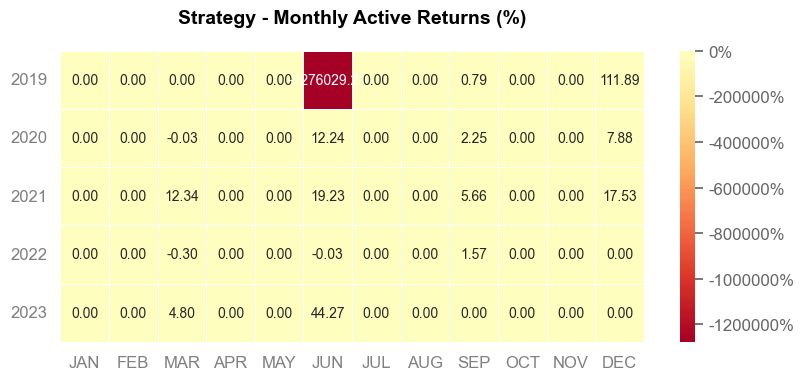

In [47]:
import quantstats as qs      
benchmark_data = yf.download('SPY', start='2018-12-31', end='2023-06-30', progress=False)['Adj Close']
qs.reports.basic(value_in_time['Portfolio Value'], benchmark = benchmark_data, rf = .05)

Avg 5Y ret:  3.7572148662192717 Q3'23 ret:  0.13777795027050854


<Axes: >

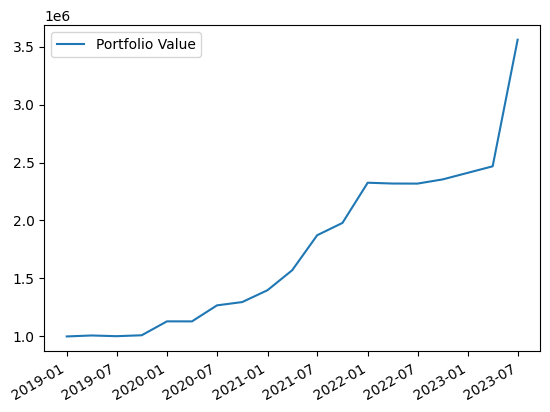

In [6]:
sims = 1
simulations = [BackTesting(new_data) for i in range(sims)]
port_vals = pd.Series([(simulations[i][0].iloc[-1] / simulations[i][0].iloc[0] -1).values[0] for i in range(sims)])
rets = np.array([return_next_q(simulations[i][1]) for i in range(len(simulations))])
print('Avg 5Y ret: ',port_vals.mean(), "Q3'23 ret: ", rets.mean())
value_in_time.plot()